## nengo DL weirdness
In this notebook, I develop a minimal working example of a nengo dl project that shows behavior against my expectations and desires. Goal of this project is to (I) understand why this behavior is occuring and (II) how to adapt this behavior towards desired outcomes.

First, I will define a set of parameters and functions and in the second part I will call these functions with different settings and compare their outcomes.

In [1]:
# run this cell once to install nengo and nengo_dl on the google backend
# ! pip install nengo nengo_dl

In [2]:
# import the necessary packages
%matplotlib inline
import nengo
import nengo_dl
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# ignore annoying warning
tf.get_logger().addFilter(lambda rec: "Tracing is expensive" not in rec.msg)

In [3]:
# here, we define a simple nengo model that is ought to learn to predict it's own input into the future

def make_model(state_dim, neurons_per_dim, neuron_type, radius, predict_delta, recurrent,
               seed, synapse_input, synapse_prediction, synapse_recurrent):

    # initialize the model weights as zeros
    weights = np.zeros((
        state_dim,
        neurons_per_dim * state_dim)
    )

    if recurrent:
        recurrent_weights = np.zeros((
            neurons_per_dim * state_dim,
            neurons_per_dim * state_dim)
        )

    model = nengo.Network(label="predictive network")
    with model:

        # disable optimization on all parameters by default
        nengo_dl.configure_settings(trainable=False)

        # set the default synapse to None (normal default is 0.005s)
        model.config[nengo.Connection].synapse = None

        # create the input node
        model.true_state = nengo.Node(
            np.zeros(state_dim),
            label="state input node"
        )

        model.filtered_input = nengo.Node(
            None,
            size_in=state_dim,
            label="filtered input node"
        )

        nengo.Connection(
            model.true_state,
            model.filtered_input,
            synapse=synapse_input,
            label="input filter"
        )


        # make the hidden layer
        model.ens = nengo.Ensemble(
            n_neurons=neurons_per_dim * state_dim,
            dimensions=state_dim,
            neuron_type=neuron_type(),
            radius=radius,
            seed=seed,
            label="predictive ensemble"
        )

        # re-enable training on Ensembles (encoders and biases) or not
        model.config[nengo.Ensemble].trainable = False

        # connect the input to the ensemble
        model.encoder = nengo.Connection(model.filtered_input, model.ens, label="input to ensemble")

        # make a node for the predicted future state
        model.predicted_future_state = nengo.Node(None, size_in=state_dim, label="predicted future state node")

        # make the output weights we can learn
        model.learned_connection = nengo.Connection(
            model.ens.neurons,
            model.predicted_future_state,
            transform=weights,
            seed=seed,
            label="ensemble to predicted future state",
            synapse=synapse_prediction
        )

        # make the connection trainable
        model.config[model.learned_connection].trainable = True

        # if desired, have the model have recurrent connections
        if recurrent:
            model.recurrent_connection = nengo.Connection(
                model.ens.neurons,
                model.ens.neurons,
                transform=recurrent_weights,
                seed=seed,
                synapse=synapse_recurrent,
                label="recurrent ensemble connection"
            )
            model.config[model.recurrent_connection].trainable = True

        # if desired, have the model predict the difference from the last state instead
        if predict_delta:
            nengo.Connection(model.filtered_input, model.predicted_future_state, label="true state to predicted future state")

        model.recordings = {
            "states": nengo.Probe(model.true_state, label="states"),
            "filtered_input": nengo.Probe(model.filtered_input, label="filtered_input"),
            "predicted_future_states": nengo.Probe(model.predicted_future_state, label="predicted_future_states")
        }

    return model

In [4]:
# next, let's define a training function that takes, amongst others, a model and optimizer object

def train(model, optimizer, inputs, targets, batch_size, epochs, seed, dt, load="", save="./params", verbose=0, sim=None):
    
    if sim is None:
        sim = nengo_dl.Simulator(model, seed=seed, minibatch_size=batch_size, dt=dt)

    if load:
        if verbose:
            print("loading weights from", load)
        sim.load_params(load)
    sim.compile(
        optimizer=optimizer,
        loss={model.recordings["predicted_future_states"]: nengo_dl.losses.nan_mse},
    )
    history = sim.fit(inputs, targets, epochs=epochs, verbose=verbose)

    if save:
        if verbose:
            print("saving weights to", save)
        sim.save_params(save)

    return history

In [5]:
# we do the same with an evaluation function but here no optimizer is given

def eval(model, inputs, targets, batch_size, seed, dt, load="", verbose=0, sim=None):
    
    if sim is None:
        sim = nengo_dl.Simulator(model, seed=seed, minibatch_size=batch_size, dt=dt)

    if load:
        if verbose:
            print("loading weights from", load)
        sim.load_params(load)

    # here, I use an optimizer with a 0 learning rate
    # I have also tried passing the same optimizer used for learning to this function but the results are the same
    sim.compile(
        optimizer=tf.optimizers.SGD(0.0, momentum=False),
        loss={model.recordings["predicted_future_states"]: nengo_dl.losses.nan_mse},
    )
    history = sim.evaluate(inputs, targets, verbose=verbose)

    return history

In [6]:
# finally, this last function is ought to produce a plot of the model predictions. Ideally, this can happen straight from the output of the evaluation and test function, but I do not know how.

def plot_prediction(model, inputs, targets, batch_size, seed, dt, load="", n=3, sim=None):
    
    if sim is None:
        sim = nengo_dl.Simulator(model, seed=seed, minibatch_size=batch_size, dt=dt)

    if load:
        print("loading weights from", load)
        sim.load_params(load)

    sim.compile(
        optimizer=tf.optimizers.SGD(0.0, momentum=False),
        loss={model.recordings["predicted_future_states"]: nengo_dl.losses.nan_mse},
    )

    t = inputs.shape[1] * dt  # in an ideal world, this would be t_present 
    sim.run(t, data={model.true_state: inputs[-batch_size:]})

    finpt = sim.data[model.recordings["filtered_input"]]
    predictions = sim.data[model.recordings["predicted_future_states"]]

    for i in range(n if n <= batch_size else batch_size):
        line0 = plt.plot(sim.trange(), inputs[-batch_size:][i], label="input", color="y")[0]
        line1 = plt.plot(sim.trange(), finpt[i], label="filtered input", color="b", linestyle="-")[0]
        line2 = plt.plot(sim.trange(), targets[-batch_size:][i], "o-", label="target", color="g", ms=3)[0]
        line3 = plt.plot(sim.trange(), predictions[i], label="prediction", color="r", linestyle="-")[0]
        plt.xlabel("time [s]")
        plt.legend([line0, line1, line2, line3], ["input", "filtered input", "target", "prediction"],
                   loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4)
        plt.show()

In [7]:
# it is time to define some parameters for the simulations

# simulation parameters
seed = 42
np.random.seed(seed)
dt = 0.02     # time step size of nengo simulation in seconds

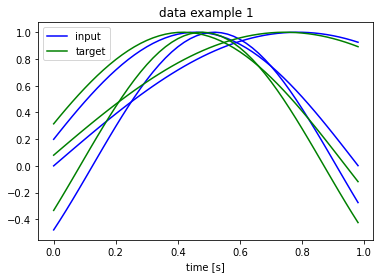

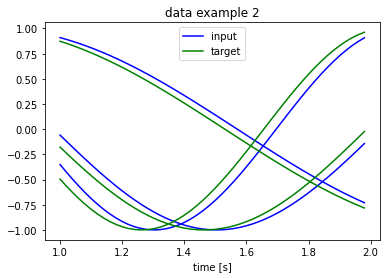

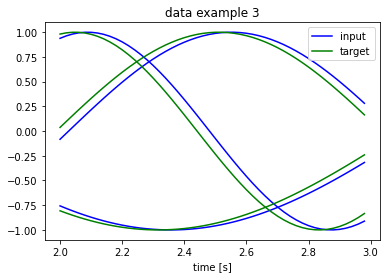

In [8]:
# let's create some dummy training data and targets

# data parameters
sample_freq = 50.    # sampling frequency of the data
t_max = 50.          # duration of training samples in seconds
t_shift = 0.04       # time to shift the target time series
t_present = 1./sample_freq # time to present each input to the network
t = np.arange(0., t_max, 1./sample_freq)
ts = t + t_shift     # determines how far into the future the input is ought to be predicted
n_examples = 50      # how many snippets of to create

# create some training data
train_data = np.array([2.*t, 3.*t+0.2, 4.*t-0.5])   
train_targets = np.array([2*ts, 3.*ts+0.2, 4.*ts-0.5])
state_dim = train_data.shape[0]   # = 3 in this example
train_data = np.sin(train_data).T
train_targets = np.sin(train_targets).T

# need shape: (# training examples, time, state_dim)
train_data = train_data.reshape(n_examples, -1, state_dim)
train_targets = train_targets.reshape(n_examples, -1, state_dim)

# take a look at an example of the data
for i in range(3):
    line1 = plt.plot(t[i*len(train_data[i]):(i+1)*len(train_data[i])], train_data[i], color="b")[0]
    line2 = plt.plot(t[i*len(train_data[i]):(i+1)*len(train_data[i])], train_targets[i], color="g")[0]
    plt.xlabel("time [s]")
    plt.legend([line1, line2], ["input", "target"])
    plt.title(f"data example {i+1}")
    plt.show()

In [9]:
# time to initialize the model object

# model parameters
neurons_per_dim = 50
neuron = "rate"
radius = 1.5
predict_delta = True
recurrent = True
synapse_input = None
synapse_prediction = 0.01
synapse_recurrent = 0.04

if neuron == "rate":
    neuron_type = nengo.LIFRate
elif neuron == "lif":
    neuron_type = nengo.LIF

# create the model
model = make_model(
    state_dim=state_dim, neurons_per_dim=neurons_per_dim, neuron_type=neuron_type, radius=radius,
    predict_delta=predict_delta, recurrent=recurrent, seed=seed, synapse_input=synapse_input,
    synapse_prediction=synapse_prediction, synapse_recurrent=synapse_recurrent,
)

# prepare model inputs
training_inputs = {model.true_state: train_data}
training_targets = {model.recordings["predicted_future_states"]: train_targets}

In [10]:
# set some important training parameters

# training parameters
batch_size = 10
epochs = 100
eval_every = 100   # how often to evaluate the model during the training process
save = "./params"
optim = "sgd"
lr = 0.000001

# initialize optimizer
if optim == "adam":
    optimizer = tf.optimizers.Adam(lr)
elif optim == "sgd":
    optimizer = tf.optimizers.SGD(lr, momentum=False)

sim = nengo_dl.Simulator(model, seed=seed, minibatch_size=batch_size, dt=dt)

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


In [11]:
# now we can evaluate the model before training to see if everything works

# record the losses
train_loss = []
test_loss = []

# do an initial evaluation
test_history = eval(model=model, inputs=training_inputs, targets=training_targets, batch_size=batch_size, seed=seed, dt=dt, 
                    verbose=1, sim=sim)
test_loss.append(test_history["loss"])

# plot_prediction(model=model, inputs=train_data, targets=train_targets, batch_size=batch_size, seed=seed, dt=dt, sim=sim)

5/5 [==============================] - 2s 60ms/step - loss: 0.0077 - predicted_future_states_loss: 0.0077


In the plot above we can see the expected model output. The model just takes the current input as the basis (prior) of it's prediction, which therefore lacks behind the target. If we change the model parameter `predict_delta` to `False`, we would instead get a prediction that is 0 throughout. I use the training data to evaluate the model. This is of course not the intended way of use in the final application, but it serves as a sanity check here and will be important later when comparing different neuron models.

Epoch 1/100
5/5 [==============================] - 2s 137ms/step - loss: 0.0078 - predicted_future_states_loss: 0.0078
Epoch 2/100
5/5 [==============================] - 1s 156ms/step - loss: 0.0072 - predicted_future_states_loss: 0.0072
Epoch 3/100
5/5 [==============================] - 1s 156ms/step - loss: 0.0069 - predicted_future_states_loss: 0.0069
Epoch 4/100
5/5 [==============================] - 1s 155ms/step - loss: 0.0072 - predicted_future_states_loss: 0.0072
Epoch 5/100
5/5 [==============================] - 1s 145ms/step - loss: 0.0069 - predicted_future_states_loss: 0.0069
Epoch 6/100
5/5 [==============================] - 1s 149ms/step - loss: 0.0062 - predicted_future_states_loss: 0.0062
Epoch 7/100
5/5 [==============================] - 1s 146ms/step - loss: 0.0052 - predicted_future_states_loss: 0.0052
Epoch 8/100
5/5 [==============================] - 1s 156ms/step - loss: 0.0051 - predicted_future_states_loss: 0.0051
Epoch 9/100
5/5 [==============================]

5/5 [==============================] - 1s 188ms/step - loss: 0.0015 - predicted_future_states_loss: 0.0015
Epoch 70/100
5/5 [==============================] - 1s 199ms/step - loss: 0.0014 - predicted_future_states_loss: 0.0014
Epoch 71/100
5/5 [==============================] - 1s 167ms/step - loss: 0.0016 - predicted_future_states_loss: 0.0016
Epoch 72/100
5/5 [==============================] - 1s 181ms/step - loss: 0.0014 - predicted_future_states_loss: 0.0014
Epoch 73/100
5/5 [==============================] - 1s 186ms/step - loss: 0.0014 - predicted_future_states_loss: 0.0014
Epoch 74/100
5/5 [==============================] - 1s 191ms/step - loss: 0.0013 - predicted_future_states_loss: 0.0013
Epoch 75/100
5/5 [==============================] - 1s 217ms/step - loss: 0.0013 - predicted_future_states_loss: 0.0013
Epoch 76/100
5/5 [==============================] - 1s 174ms/step - loss: 0.0015 - predicted_future_states_loss: 0.0015
Epoch 77/100
5/5 [==============================] - 1

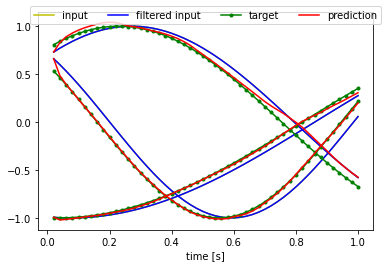

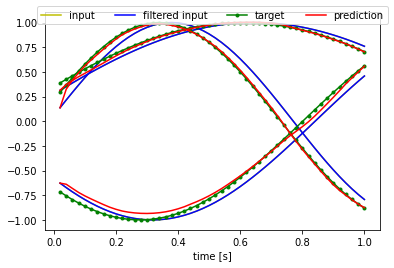

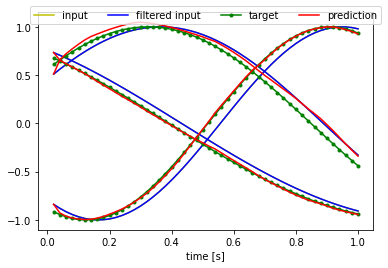

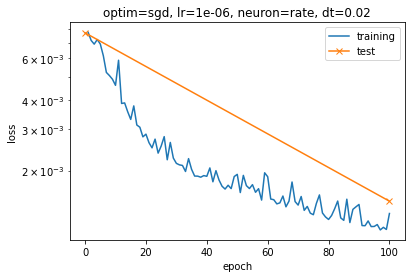

initial loss:        0.0077126771211624146
final training loss: 0.0013158816145732999
final test loss:     0.0014845150290057063


In [12]:
# now lets run some training and see how the model prediction develops

# training and evaluation loop
for e in range(1, epochs+1, eval_every):

    train_history = train(model=model, optimizer=optimizer, inputs=training_inputs, targets=training_targets,
                    batch_size=batch_size, epochs=eval_every, seed=seed, dt=dt, load="" if e == 1 else save,
                    save=save, verbose=1, sim=sim)

    for l in train_history.history["loss"]:
        train_loss.append(l)

    test_history = eval(model=model, inputs=training_inputs, targets=training_targets, batch_size=batch_size, 
                        seed=seed, dt=dt, load=save, verbose=1, sim=sim)

    test_loss.append(test_history["loss"])

plot_prediction(model=model, inputs=train_data, targets=train_targets, batch_size=batch_size, seed=seed,
                dt=dt, load=save, sim=sim)

# plot the losses
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label="training")
plt.plot(np.arange(0, len(train_loss)+1, eval_every), test_loss, label="test", marker="x")
plt.yscale("log")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.title(f"optim={optim}, lr={lr}, neuron={neuron}, dt={dt}")
plt.show()

print("initial loss:       ", test_loss[0])
print("final training loss:", train_loss[-1])
print("final test loss:    ", test_loss[-1])


The first observation the model is learning the prediction task to an extend, as both training and test loss decrease and the prediction is much closer to the target after training.

As we want to run the above procedure multiple times with different parameters and primarily compare the output, I will summuarize a bunch of the code above in a single function that takes lots of arguments. Also, we will get rid of most of the printed progress.

In [13]:
def run_experiment(train_data, train_targets, state_dim=3, seed=42, dt=0.02, neurons_per_dim=50, radius=1.5, predict_delta=True,
                   recurrent=True, neuron="rate", synapse_input=None, synapse_prediction=0.01,
                   synapse_recurrent=None, batch_size=5, epochs=100, eval_every=100, save="./params", optim="sgd", lr=0.000001,
                   verbose=0):
    
    # first we make the model

    if neuron == "rate":
        neuron_type = nengo.LIFRate
    elif neuron == "lif":
        neuron_type = nengo.LIF
    else:
        raise ValueError(f"the neuron type {neuron} is not supported.")

    # create the model
    model = make_model(
        state_dim=state_dim, neurons_per_dim=neurons_per_dim, neuron_type=neuron_type, radius=radius,
        predict_delta=predict_delta, recurrent=recurrent, seed=seed, synapse_input=synapse_input,
        synapse_prediction=synapse_prediction, synapse_recurrent=synapse_recurrent,
    )

    # prepare model inputs
    training_inputs = {model.true_state: train_data}
    training_targets = {model.recordings["predicted_future_states"]: train_targets}

    # initialize optimizer
    if optim == "adam":
        optimizer = tf.optimizers.Adam(lr)
    elif optim == "sgd":
        optimizer = tf.optimizers.SGD(lr, momentum=False)
    else:
        raise ValueError(f"the optimizer {optim} is not supported.")
    
    # Make the sim object
    sim = nengo_dl.Simulator(model, seed=seed, minibatch_size=batch_size, dt=dt)
    
    # record the losses
    train_loss = []
    test_loss = []

    # do an initial evaluation
    test_history = eval(model=model, inputs=training_inputs, targets=training_targets, batch_size=batch_size, seed=seed, dt=dt, 
                        verbose=verbose, sim=sim)
    test_loss.append(test_history["loss"])

    plot_prediction(model=model, inputs=train_data, targets=train_targets, batch_size=batch_size, seed=seed, dt=dt, sim=sim)

    if epochs > 0:
        # training and evaluation loop
        for e in range(1, epochs+1, eval_every):

            train_history = train(model=model, optimizer=optimizer, inputs=training_inputs, targets=training_targets,
                            batch_size=batch_size, epochs=eval_every, seed=seed, dt=dt, load="" if e == 1 else save,
                            save=save, verbose=verbose, sim=sim)

            for l in train_history.history["loss"]:
                train_loss.append(l)

            test_history = eval(model=model, inputs=training_inputs, targets=training_targets, batch_size=batch_size, 
                                seed=seed, dt=dt, load=save, verbose=verbose, sim=sim)

            test_loss.append(test_history["loss"])

#         plot_prediction(model=model, inputs=train_data, targets=train_targets, batch_size=batch_size, seed=seed,
#                         dt=dt, load=save, sim=sim)

        # plot the losses
        plt.plot(np.arange(1, len(train_loss)+1), train_loss, label="training")
        plt.plot(np.arange(0, len(train_loss)+1, eval_every), test_loss, label="test", marker="x")
        plt.yscale("log")
        plt.ylabel("loss")
        plt.xlabel("epoch")
        plt.legend()
        plt.title(f"optim={optim}, lr={lr}, neuron={neuron}, dt={dt}")
        plt.show()

    print("final training loss:", train_loss[-1])
    print("final test loss:    ", test_loss[-1])
    print("initial loss:       ", test_loss[0])
    
    sim.close()

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Simulation finished in 0:00:00                                                 


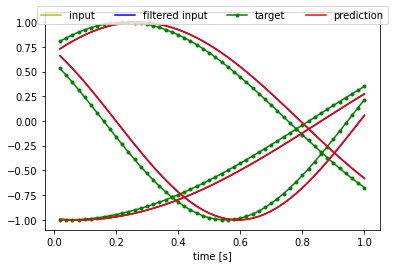

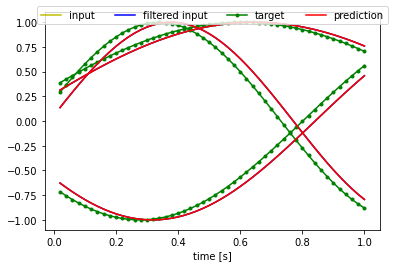

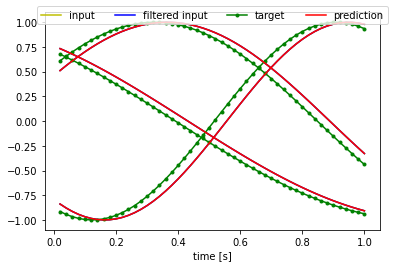

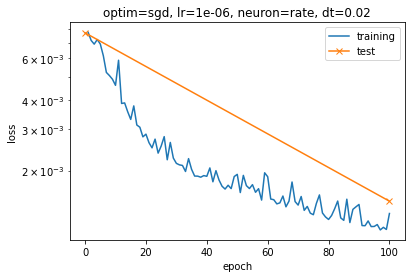

final training loss: 0.0013158816145732999
final test loss:     0.0014845150290057063
initial loss:        0.0077126771211624146
Wall time: 1min 14s


In [14]:
# summarize all important parameters in one place
parameters = dict(
    # the first four, we will leave constant over the coming runs
    train_data=train_data,
    train_targets=train_targets,
    state_dim=state_dim,
    seed=42,
    # simulation parameter
    dt=0.02,
    # model parameters
    neurons_per_dim=50,
    radius=1.5,
    predict_delta=True,
    recurrent=True,
    neuron="rate",
    synapse_input=None,
    synapse_prediction=0.01,
    synapse_recurrent=0.04,
    # training parameters
    batch_size=10,
    epochs=100,
    eval_every=100,
    optim = "sgd",
    lr = 0.000001,
    save="./params",
    # misc
    verbose=0
)

# run and time the experiment
%time run_experiment(**parameters)

As expected, when running the same parameters twice in a row, including the same random seed, the results are exactly the same. In both runs the models were evaluated only before and after training of 100 epochs. 

In the next run I will also evalute the model after 50 epochs of training. In general, it is desirable and common practice to continously evaluate a model during the training process. This evluation of the model should not have any influence on the model, it's (hidden) parameters and their learning process. However, in the following run, we can see that this is not the case here. The first questions I have is, (1.) why the training process is influenced by separating it into several steps and (2.) how to prevent this from happening.

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Simulation finished in 0:00:00                                                 


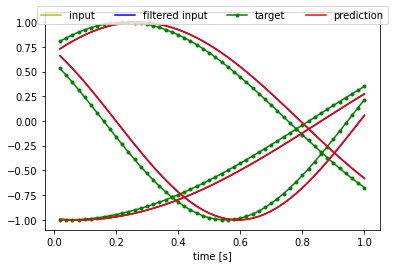

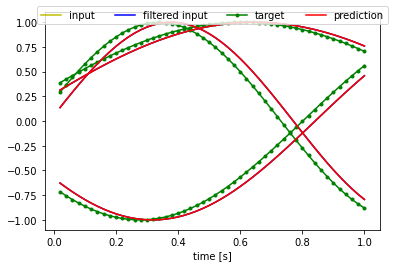

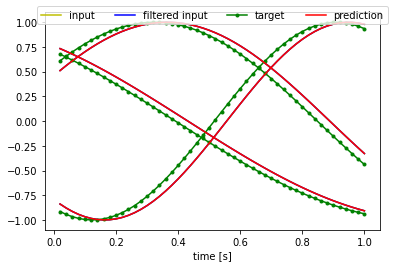

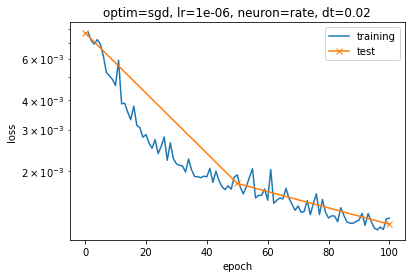

final training loss: 0.001267021638341248
final test loss:     0.0011923995334655046
initial loss:        0.0077126771211624146
Wall time: 1min 21s


In [15]:
# update parameters
parameters.update(dict(
    eval_every=50
))

# run and time the experiment
%time run_experiment(**parameters)

This effect of the evaluation on the training process is even more obvious when using the Adam optimizer. 

I have checked if the results are different, when the same optimizer object is passed from the training function, to the evaluation function and back. However, there is no difference to just initializing an optimizer with a learning rate of 0.0 for each call of the evluation function.

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Simulation finished in 0:00:00                                                 


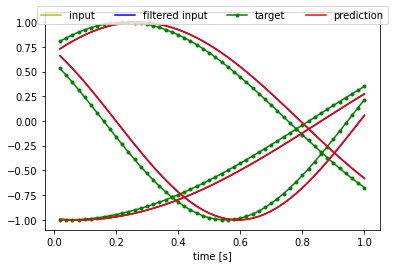

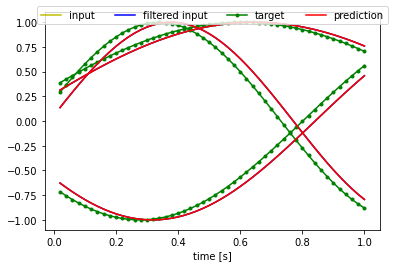

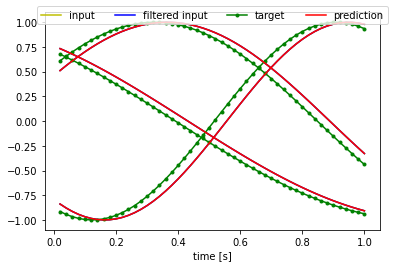

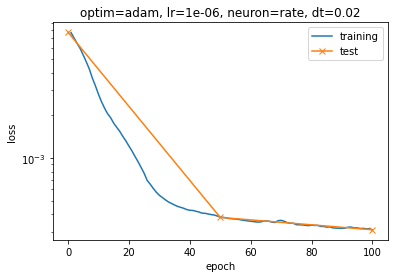

final training loss: 0.0003107439260929823
final test loss:     0.00031155385659076273
initial loss:        0.0077126771211624146
Wall time: 1min 18s


In [16]:
# update parameters
parameters.update(dict(
    optim="adam"
))

# run and time the experiment
%time run_experiment(**parameters)